# Overview

We implement Neural Network from Scratch in this notebook. The basic concepts are illustrate in article [Neural Network from Scratch]().

In [13]:
%%capture
!pip install graphviz==0.20.1

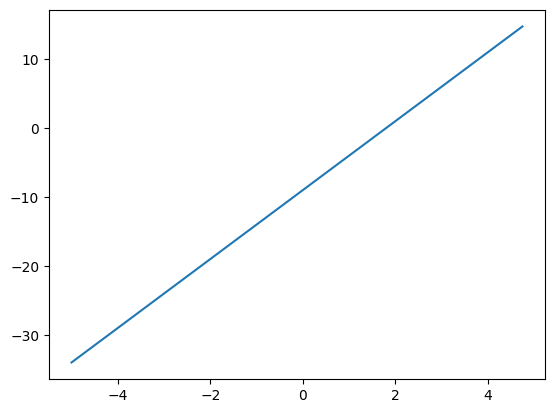

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def func(x):
    return 5*x -9

xs=np.arange(-5,5,0.25)
ys=func(xs)
plt.plot(xs, ys)

# Implementation of a Value in Neural Network

In [12]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data=data
        self.label=label
        self._op=_op
        self._prev=set(_children)
        self.grad=0

    def __repr__(self):
        return f"Value=(data={self.data}, label={self.label})"
    
    def __add__(self, value):
        out=Value(self.data+value.data, (self, value), "+")
        return out
    
    def __mul__(self, value):
        out=Value(self.data*value.data, (self, value), "*")
        return out
        
    
a=Value(2.0, label="a")
b=Value(-3.0,label="b")
c=Value(10.0, label="c")
e=a*b; e.label="e"
d=e+c; d.label="d"
f=Value(-2.0, label='f')
L=d*f; L.label='L'
L

Value=(data=-8.0, label=L)

# Visualizing Neural Network

we are goigng to use `graphviz` library to creating the describtion graph in DOT language.

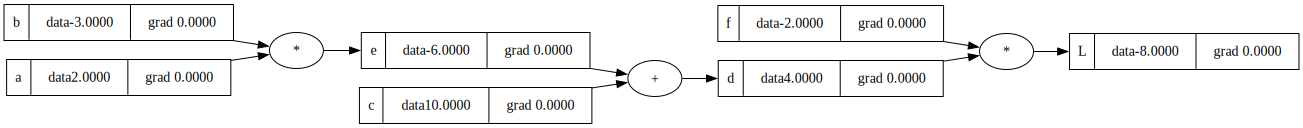

In [15]:
from graphviz import Digraph

def trace(root):
    nodes, edges=set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot=Digraph(format='png', graph_attr={'rankdir':'LR'}) # LR=left to right
    
    nodes, edges=trace(root)
    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid, label="{%s|data%.4f|grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot

draw_dot(L)

# Acknowledge
* https://pub.towardsai.net/neural-network-from-scratch-6fa1e78a3515
* https://www.mathsisfun.com/calculus/derivatives-introduction.html
* https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_second_half_roughly.ipynb